## Training and Testing Sentiment Classification Model

In this Jupyter File, we will use the a Benchmark Dataset containing User Reviews of Covid-19 Contact Tracing apps from 46 countries to Train and test our Sentiment Analysis model which uses BERT (Bi-directional Encoder Representations From Transformers). Reference for the Dataset used in this code - https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/1RDRCM. There user reviews are divided into two datasets files here. The names of these two dataset files are t2_data_train.tsv and t2_data_test.tsv.
We will split t2_data_train.tsv to create a training set and validation set. Training set will be used to trained the model and Validation set will be used to check it accuracy while tuning the model. 
Finally, we will use t2_data_test.tsv to check the accuracy of the model on new unseen data.

In [1]:
# Transformers installation
! pip install transformers

     ---------------------------------------- 4.7/4.7 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 101.5/101.5 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 78.4/78.4 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 2.9 MB/s eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 4.6 MB/s eta 0:00:00
     -------------------------------------- 262.7/262.7 kB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 62.8/62.8 kB 3.3 MB/s eta 0:00:00
     -------------------------------------- 139.9/139.9 kB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 61.2/61.2 kB 3.2 MB/s eta 0:00:00
     -------------------------------------- 160.2/160.2 kB 4.8 MB/s eta 0:00:00


In [3]:
! pip install tensorflow

     ------------------------------------ 444.1/444.1 MB 900.2 kB/s eta 0:00:00
     -------------------------------------- 895.5/895.5 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     -------------------------------------- 123.4/123.4 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 2.0 MB/s eta 0:00:00
     -------------------------------------- 438.7/438.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.6/1.6 MB 238.2 kB/s eta 0:00:00
     -------------------------------------- 42.6/42.6 kB 688.1 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 583.7 kB/s eta 0:00:00
     -------------------------------------- 57.5/57.5 kB 605.5 kB/s eta 0:00:00
     -----------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Reading the Training Datset and storing it in a dataframe
df = pd.read_csv('t2_data_train.tsv', sep='\t')

In [4]:
# column text contains the user reviews and column class_label has the sentiment score.
df.head()

,id,text,class_label
0,0,Trying to to register but showing : could not ...,1
1,1,I don’t get it it should be data free why shou...,1
2,2,"Good initiative, haven't noticed any extra bat...",0
3,3,Battery drainage and activation error messages,1
4,4,Good,0


class_label value 1 means the user review is negative and the class_label value 0 means that the user review is positive.

In [5]:
data = df.copy()

In [6]:
data.head()

,id,text,class_label
0,0,Trying to to register but showing : could not ...,1
1,1,I don’t get it it should be data free why shou...,1
2,2,"Good initiative, haven't noticed any extra bat...",0
3,3,Battery drainage and activation error messages,1
4,4,Good,0


In [7]:
data.shape

(22286, 3)

In [8]:
X=list(df['text'])

In [9]:
#X

In [10]:
Y = list(df['class_label'])

In [11]:
#Y

## Training the Sentiment Classifier Model

Here will will train the Distill BERT  which is the distilled version of the base bert. Reference used for training the sentiment classifier model- https://github.com/krishnaik06/Huggingfacetransformer

In [2]:
from transformers import DistilBertTokenizerFast

In [3]:
# We will use distill bert which is a distilled version of bert base model.
model_name= "distilbert-base-uncased"

In [4]:
# Reference https://huggingface.co/docs/transformers/model_doc/distilbert
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

In [15]:
#Train test split
from sklearn.model_selection import train_test_split

In [16]:
# X_train, and Y_train will be used to train the Distill Bert Uncased Model,
# and X_test and Y_test will be used to as Validation set to check accuracy of the model
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

In [17]:
# Converting the Text into embeddings using DistilBertTokenizerFast Tokenizer
train_encodings = tokenizer(X, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [4]:
import tensorflow as tf

In [19]:
# train_dataset will be used to train the model
# test_dataset will be used to check the accuracy of the model while tuning the hyper parameteres of the model
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    Y
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    Y_test
))

In [20]:
train_dataset

<TensorSliceDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [6]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

In [7]:
# Selecting the training arguments for the Distill bert Uncased model
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total no. of training epochs
    per_device_train_batch_size=2,  # batch size per device during training
    per_device_eval_batch_size=2,   # batch size for evaluation
    warmup_steps=500,                # no. of warmup-steps for learning rate scheduler
    weight_decay=0.01,               # weight decay strength
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps = 10,
    save_total_limit = 2,
)

In [23]:
# training the sentiment classifier model
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained(model_name)

trainer = TFTrainer(
    model=model,                         # instantiated Hugging Transformers model to be trained
    args=training_args,                  # training arguments that we defined in the previous cell
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [30]:
# saving the trained model
trainer.save_model('./trainedmodel')

Now that we have trained our sentiment classification model, we will check its accuracy by predictiong the sentiment (0 -  positive or 1 - negative) on Validations set. Validation set is being used to tune the model while checking its accuracy.

In [27]:
output = trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)

In [31]:
output

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [19]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [33]:
cf = confusion_matrix(Y_test,output)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

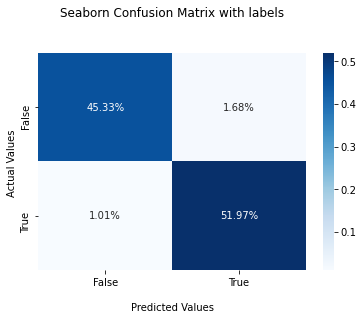

In [35]:
ax = sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

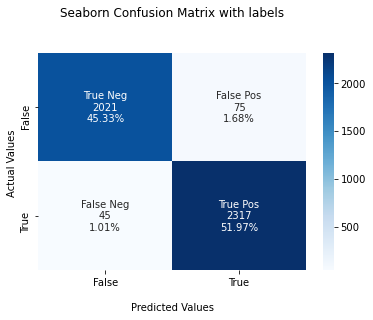

In [36]:
# assigning proper naming to the confusion matrix that we created in the previous cell.
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

From this confusion matrix we can see that we have achieved very good results on the validation set. As we Know Accuracy is calculate as (TP + TN)/(TP + TN + FP +FN) * 100, where TP = True Positive, TN = True Negative, FP = False Positive, FN = False Negative. The Accuracy on Validation set = **97.31 %**.

### Predictions on Test Data

We have successfully trained the model and tuned it. Now that we are satisfied with that accuracy on the Validation dataset, we will load a new Test Dataset and Check the accuracy of the sentiment classifier model on it. Name of the test dataset is t2_data_test.tsv

In [8]:
df_1 = pd.read_csv('t2_data_test.tsv', sep='\t')

In [9]:
df_1.head()

,id,text,class_label
0,0,Useless. Don't bother.,1
1,1,Good,0
2,2,Says phone number invalid! Unable to complete ...,1
3,3,Very good,0
4,4,"Same with others, why it is always crashing?? ...",1


In [10]:
X_1=list(df_1['text'])

In [11]:
Y_1=list(df_1['class_label'])

In [12]:
X_1_encodings = tokenizer(X_1, truncation=True, padding=True)

In [13]:
final_test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_1_encodings),
    Y_1
))

In [45]:
output_1 = trainer.predict(final_test_dataset)[0]
output_1 = np.argmax(output_1, axis = - 1)

In [46]:
output_1

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [47]:
cf_1 = confusion_matrix(Y_1,output_1)

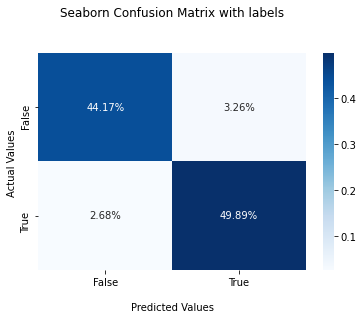

In [48]:
ax = sns.heatmap(cf_1/np.sum(cf_1), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Now, we will conclude this code by loading the saved model and testing it again.

In [14]:
model_1 = TFDistilBertForSequenceClassification.from_pretrained("./trainedmodel", local_files_only=True)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ./trainedmodel.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [15]:
trainer_1 = TFTrainer(model=model_1, args=training_args)

In [16]:
output_2 = trainer_1.predict(final_test_dataset)[0]
output_2 = np.argmax(output_2, axis = - 1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [17]:
output_2

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [21]:
cf_2 = confusion_matrix(Y_1,output_2)

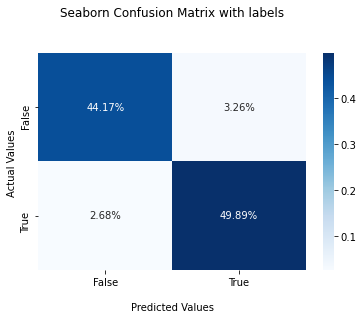

In [22]:
ax = sns.heatmap(cf_2/np.sum(cf_2), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

As we can see, we have achieved high values for True Negative and True Positive. It means the accuracy of our model is very good on Unseen Test Data. As we Know Accuracy is calculate as (TP + TN)/(TP + TN + FP +FN) * 100, where TP = True Positive, TN = True Negative, FP = False Positive, FN = False Negative. So the Accuracy of our Model on Test Data is = **94.06 %**.